### Figure 3: Mean and STD bias plot

In [1]:
import numpy as np
from libpysal.weights import lat2W
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xesmf as xe
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def plot_anomaly(inputs,cmap,plot='save',vmin=-1,vmax=1,levels = False,mode='validation'):  
        fig, ax = plt.subplots(figsize=(5, 5))  
        ax.set_title('Anomaly')
        im = ax.imshow(inputs, interpolation='nearest', vmin=vmin,vmax=vmax,extent=None,cmap=cmap)
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        if levels:
                plt.colorbar(im, cax=cax,levels = levels) # Similar to fig.colorbar(im, cax = cax)
        else:
                plt.colorbar(im, cax=cax)
        # plt.colorbar(im)

        if plot == 'save':
                plt.savefig('figs/input_images_%s.png' % mode,bbox_inches='tight')
                plt.clf()
        else:
                plt.show()

In [3]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

real = np.load('/user/home/al18709/work/gan_predictions_20/validation_real-opt_improve.npy')[:,:,:,0]
inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid_2.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')[:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_improve.npy')[:,:,:,0]
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_improve.npy')
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]


# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)


(16253, 10, 10)


In [11]:
def mean(real,pred):
	# mean_real = np.nanmean(real,axis=0)
	# mean_pred = np.nanmean(pred,axis=0)
	mean_real = stats.trim_mean(real, 0.001)
	mean_pred = stats.trim_mean(pred, 0.001)

	mean_anom = mean_pred - mean_real
	mean_anom = mean_anom/mean_real * 100
	return mean_anom

def std(real,pred):
	std_real = np.nanstd(real,axis=0)
	std_pred = np.nanstd(pred,axis=0)
	std_anom = std_pred - std_real
	std_anom = std_anom/std_real * 100
	return std_anom


In [12]:
# calc means etc

mean_anom_unet = mean(real,pred_cnn)
std_anom_unet = std(real,pred_cnn)
mean_anom_vaegan = mean(real,pred_vaegan)
std_anom_vaegan = std(real,pred_vaegan)
mean_anom_dsrnngan = mean(real,pred_dsrnngan)
std_anom_dsrnngan = std(real,pred_dsrnngan)
mean_anom_inputs = mean(real,inputs_hr)
std_anom_inputs = std(real,inputs_hr)




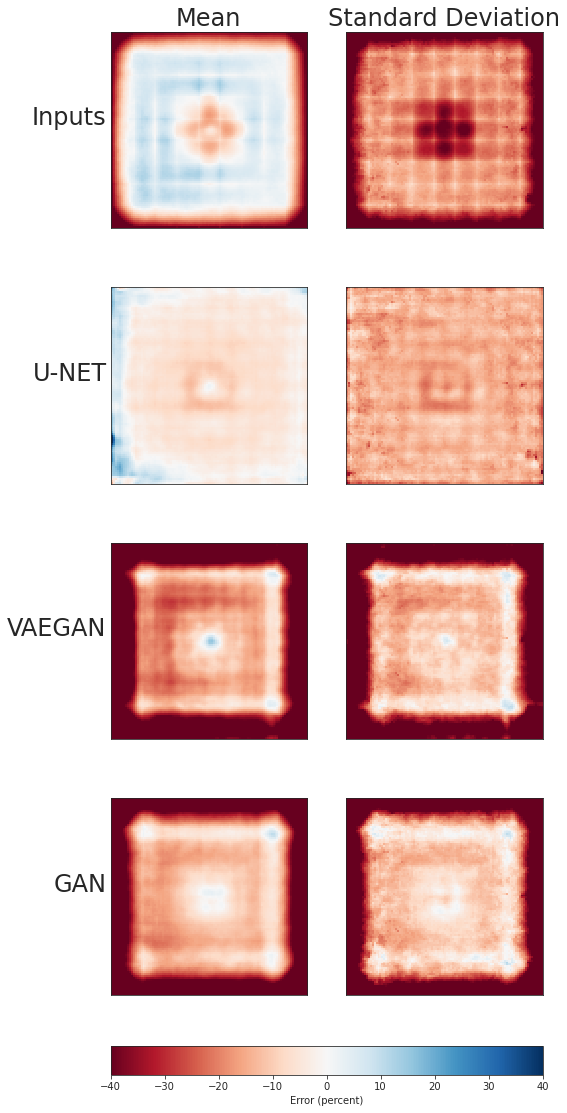

In [13]:
plot='save'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)


axes[0,0].imshow(mean_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,0].imshow(mean_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,0].imshow(mean_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[3,0].imshow(mean_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[0,1].imshow(std_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,1].imshow(std_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,1].imshow(std_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
m = axes[3,1].imshow(std_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])



# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Error (percent)')

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_title('Mean',fontsize=24)
axes[0,1].set_title('Standard Deviation',fontsize=24)
axes[0,0].set_ylabel('Inputs',rotation=0,ha='right',fontsize=24)
axes[1,0].set_ylabel('U-NET',rotation=0,ha='right',fontsize=24)
axes[2,0].set_ylabel('VAEGAN',rotation=0,ha='right',fontsize=24)
axes[3,0].set_ylabel('GAN',rotation=0,ha='right',fontsize=24)




# plt.tight_layout()
# plt.colorbar(m)
plt.savefig('figure3.png',bbox_inches='tight')
# plt.show()

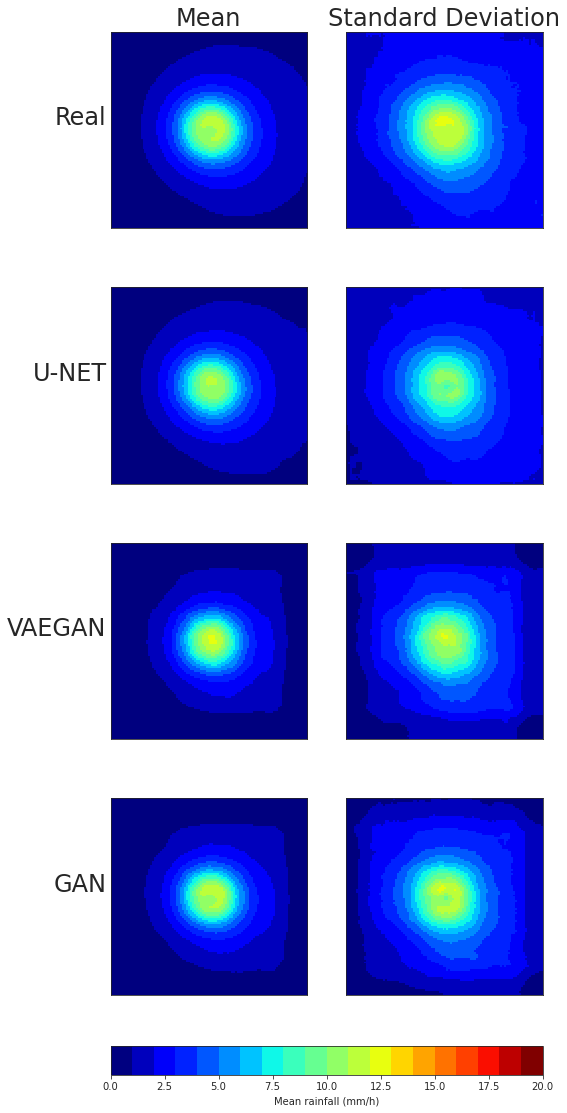

In [14]:
plot='save'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)

cmap = plt.get_cmap('jet', 20)

axes[0,0].imshow(stats.trim_mean(real, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[1,0].imshow(stats.trim_mean(pred_cnn, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[2,0].imshow(stats.trim_mean(pred_vaegan, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[3,0].imshow(stats.trim_mean(pred_dsrnngan, 0.05), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[0,1].imshow(np.nanstd(real,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[1,1].imshow(np.nanstd(pred_cnn,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
axes[2,1].imshow(np.nanstd(pred_vaegan,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)
m = axes[3,1].imshow(np.nanstd(pred_dsrnngan,axis=0), interpolation='nearest', extent=None,cmap=cmap,vmin=0,vmax=20)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# radar_log meteomatic


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Mean rainfall (mm/h)')

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_title('Mean',fontsize=24)
axes[0,1].set_title('Standard Deviation',fontsize=24)
axes[0,0].set_ylabel('Real',rotation=0,ha='right',fontsize=24)
axes[1,0].set_ylabel('U-NET',rotation=0,ha='right',fontsize=24)
axes[2,0].set_ylabel('VAEGAN',rotation=0,ha='right',fontsize=24)
axes[3,0].set_ylabel('GAN',rotation=0,ha='right',fontsize=24)




# fig.tight_layout()
# plt.colorbar(m)
plt.savefig('figure4.png',bbox_inches='tight')
# plt.show()

In [15]:
# TODO: switch to 'zero padding' instead of reflect padding - already using zero padding

# 
# Andrew M
#   12:35 PM
# Ok, so in summary
# your data is different to ours coz you always have interesting things in the middle rather than randomly anywhere

# try switching the generator to something with less padding (e.g. the U-Net you already have, but with noise introduced somewhere)

# if weird edge stuff still happens, try getting rid of the padding in the low-resolution parts of the discriminator (happy to advise on this!)

In [16]:
# load data
real = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_real-opt_improve.npy')[:,:,:,0]
inputs = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_input-opt_improve.npy')[:,:,:,0]
pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_6.npy')[:,:,:,0]
# pred_cnn = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve.npy')[:,:,:,0]
# pred_cnn = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_7.npy')[:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve_2.npy')[:,:,:,0]
# pred_dsrnngan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve_5.npy')[:,:,:,0]
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/extreme_valid_pred-opt_improve.npy')[:,:,:,0]
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_improve_6.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

# calc means etc
mean_anom_unet = mean(real,pred_cnn)
std_anom_unet = std(real,pred_cnn)
mean_anom_vaegan = mean(real,pred_vaegan)
std_anom_vaegan = std(real,pred_vaegan)
mean_anom_dsrnngan = mean(real,pred_dsrnngan)
std_anom_dsrnngan = std(real,pred_dsrnngan)
mean_anom_inputs = mean(real,inputs_hr)
std_anom_inputs = std(real,inputs_hr)

show


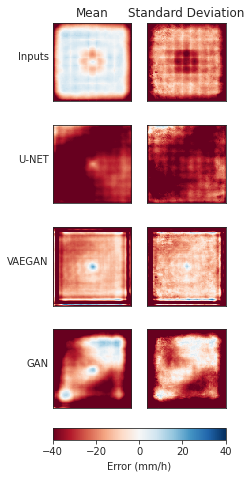

In [17]:
plot='show'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)

axes[0,0].imshow(mean_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,0].imshow(mean_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,0].imshow(mean_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[3,0].imshow(mean_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[0,1].imshow(std_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[1,1].imshow(std_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
axes[2,1].imshow(std_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
m = axes[3,1].imshow(std_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-40,vmax=40)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])


fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.6, 0.02])
cbar = fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Error (mm/h)')

# set all titles and labels
fig.subplots_adjust(left=0.3)
axes[0,0].set_title('Mean')
axes[0,1].set_title('Standard Deviation')
axes[0,0].set_ylabel('Inputs',rotation=0,ha='right')
axes[1,0].set_ylabel('U-NET',rotation=0,ha='right')
axes[2,0].set_ylabel('VAEGAN',rotation=0,ha='right')
axes[3,0].set_ylabel('GAN',rotation=0,ha='right')
plt.show()

In [ ]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/using-constant-padding-reflection-padding-and-replication-padding-with-keras.md